# Initialize Libraries

In [ ]:
# install yfinance for API connectivity
!pip install yfinance

# import libraries
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf

import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.recurrent import LSTM, GRU

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error
import numpy as np

     |████████████████████████████████| 6.3 MB 7.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# Import S&P 500 Data from Yahoo Finance

In [ ]:
# calibrate/ execute API call for SP500 Index 
yf.pdr_override()
sp500 = pdr.get_data_yahoo("^GSPC",              # S&P 500 index ticker
                           start ="2015-01-01",  # Start Date
                           end   ="2020-01-01")  # End Date

sp500 = sp500.reset_index()      

display(sp500)

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
1,2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2,2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
3,2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
4,2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000
...,...,...,...,...,...,...,...
1253,2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,3223.379883,1296540000
1254,2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2160680000
1255,2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2428670000
1256,2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,3221.290039,3013290000


# Plot Data

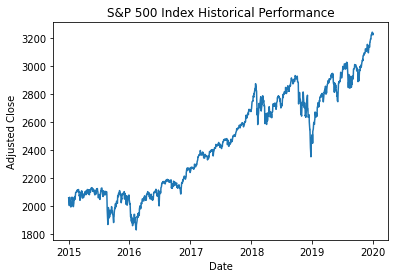

In [ ]:
plt.plot(sp500['Date'],sp500['Adj Close'])
plt.title('S&P 500 Index Historical Performance')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.show()

# Test/ Training Set Split

In [ ]:
train = sp500.head(int(len(sp500)*(.80)))     # first 80% of history - used for training/ development set
test  = sp500.tail(int(len(sp500)*(.201)))    # last 20% of history  - used for test/ forecasting set

print(f'Training set Obs: {len(train)} \nTest set Obs: {len(test)} \nS&P 500 set Obs: {len(sp500)}')

Training set Obs: 1006 
Test set Obs: 252 
S&P 500 set Obs: 1258


# Data Processing

In [ ]:
train_set = train.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 1006):
  X_train.append(training_set_scaled[i-60:i, 0])
  y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Model 1: LSTM Recurrent Model 

In [ ]:
# Initialize RNN
regressor = Sequential()
# First Layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Drop out
regressor.add(Dropout(0.2))
# Second layer
regressor.add(LSTM(units = 50, return_sequences = True))
# Drop out
regressor.add(Dropout(0.2))
# Third Layer
regressor.add(LSTM(units = 50, return_sequences = True))
# Drop out
regressor.add(Dropout(0.2))
# Fourth Layer 
regressor.add(LSTM(units = 50))
# Drop out
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

# compile & fit model
regressor.compile(optimizer = 'adam', 
                  loss      = 'mean_squared_error')
regressor.fit(X_train, 
              y_train, 
              epochs     = 5,
              batch_size = 32)

# test data & preprocessing
real_stock_price = test.iloc[:, 1:2].values
dataset_total = pd.concat((train['Open'], test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 252):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predictions
predicted_stock_price1 = regressor.predict(X_test)
predicted_stock_price1 = sc.inverse_transform(predicted_stock_price1)

Epoch 1/5
30/30 [==============================] - 18s 265ms/step - loss: 0.0555
Epoch 2/5
30/30 [==============================] - 8s 264ms/step - loss: 0.0074
Epoch 3/5
30/30 [==============================] - 8s 263ms/step - loss: 0.0059
Epoch 4/5
30/30 [==============================] - 8s 263ms/step - loss: 0.0051
Epoch 5/5
30/30 [==============================] - 8s 265ms/step - loss: 0.0051


# Model 2: Simple RNN

In [ ]:
#Initialize RNN
regressor = Sequential()  
# First RNN layer 
regressor.add(SimpleRNN(units = 50, 
                        activation='tanh', 
                        return_sequences=True, 
                        input_shape = (X_train.shape[1],1))) 
# Dropout regularization
regressor.add(Dropout(0.2))
# Second RNN layer
regressor.add(SimpleRNN(units = 50, 
                        activation='tanh', 
                        return_sequences=True))  
# Dropout regularization
regressor.add(Dropout(0.2))
# Third RNN layer
regressor.add(SimpleRNN(units = 50, activation='tanh', return_sequences=True)) 
# Dropout regularization
regressor.add(Dropout(0.2))
# Fourth RNN layer
regressor.add(SimpleRNN(units = 50)) 
# Dropout regularization
regressor.add(Dropout(0.2)) 
# Output layer
regressor.add(Dense(units = 1)) 

#Compile RNN
regressor.compile(optimizer='adam', 
                  loss='mean_squared_error') 

#Fitting the RNN to the Training set
regressor.fit(X_train, y_train,  
              epochs=5, 
              batch_size=32) 

# Test data & preprocessing
real_stock_price = test.iloc[:, 1:2].values
dataset_total = pd.concat((train['Open'], test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 252):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predictions
predicted_stock_price2 = regressor.predict(X_test)
predicted_stock_price2 = sc.inverse_transform(predicted_stock_price2)

Epoch 1/5
30/30 [==============================] - 5s 60ms/step - loss: 0.3757
Epoch 2/5
30/30 [==============================] - 2s 61ms/step - loss: 0.2551
Epoch 3/5
30/30 [==============================] - 2s 60ms/step - loss: 0.1988
Epoch 4/5
30/30 [==============================] - 2s 59ms/step - loss: 0.1572
Epoch 5/5
30/30 [==============================] - 2s 62ms/step - loss: 0.1260


# Model 3: GRU

In [ ]:
#Initialize RNN
regressor = Sequential()
# First Layer
regressor.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Add Drop Out
regressor.add(Dropout(0.2))
# Second Layer
regressor.add(GRU(units = 50, return_sequences = True))
# Add Drop Out
regressor.add(Dropout(0.2))
# Third Layer
regressor.add(GRU(units = 50, return_sequences = True))
# Add Drop Out
regressor.add(Dropout(0.2))
# Fourth Layer
regressor.add(GRU(units = 50))
# Add Drop Out
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

# Compile RNN
regressor.compile(optimizer='adam', 
                  loss='mean_squared_error') 

#Fitting the RNN to the Training set 
regressor.fit(X_train, y_train, 
              epochs=5, 
              batch_size=32) 

# Test data & preprocessing
real_stock_price = test.iloc[:, 1:2].values
dataset_total = pd.concat((train['Open'], test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 252):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predictions
predicted_stock_price3 = regressor.predict(X_test)
predicted_stock_price3 = sc.inverse_transform(predicted_stock_price3)

Epoch 1/5
30/30 [==============================] - 16s 230ms/step - loss: 0.0514
Epoch 2/5
30/30 [==============================] - 7s 230ms/step - loss: 0.0081
Epoch 3/5
30/30 [==============================] - 7s 229ms/step - loss: 0.0065
Epoch 4/5
30/30 [==============================] - 7s 228ms/step - loss: 0.0058
Epoch 5/5
30/30 [==============================] - 7s 230ms/step - loss: 0.0053


# Model Evaluation

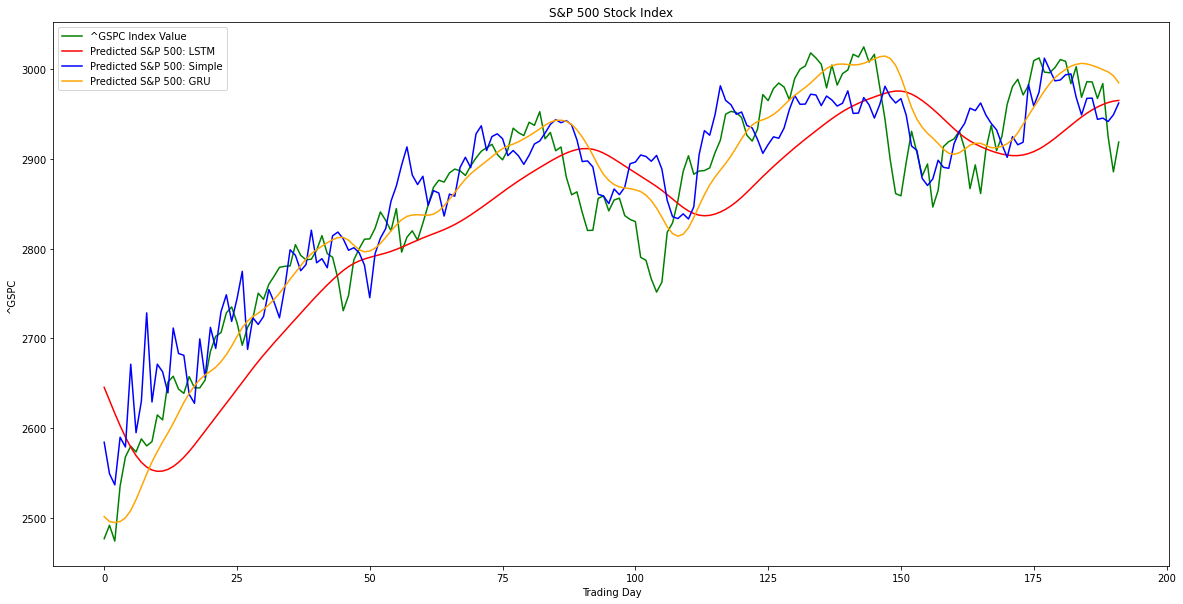

Model 1 Error: 64.04077448351792 (LSTM)
Model 2 Error: 47.54993697753367 (Simple)
Model 3 Error: 40.16610392230301 (GRU)


In [ ]:
# Set figure size 
plt.figure(figsize=(20,10))

# plot actual S&P 500 Stock prices - first 192 days 
plt.plot(real_stock_price[:192], color = 'green', label = '^GSPC Index Value')

# plot S&P 500 market predictions
plt.plot(predicted_stock_price1, color = 'red',  label = 'Predicted S&P 500: LSTM')
plt.plot(predicted_stock_price2, color = 'blue', label = 'Predicted S&P 500: Simple')
plt.plot(predicted_stock_price3, color = 'orange',  label = 'Predicted S&P 500: GRU')

# Plot Characteristic
plt.title('S&P 500 Stock Index')
plt.xlabel('Trading Day')
plt.ylabel('^GSPC')
plt.legend()
plt.show()

# Calculate Errors
model1 = np.sqrt(mean_squared_error(real_stock_price[:192],predicted_stock_price1))
model2 = np.sqrt(mean_squared_error(real_stock_price[:192],predicted_stock_price2))
model3 = np.sqrt(mean_squared_error(real_stock_price[:192],predicted_stock_price3))

# print calculated errors
print(f'Model 1 Error: {model1} (LSTM)\nModel 2 Error: {model2} (Simple)\nModel 3 Error: {model3} (GRU)')